In [1]:
# These are the libraries will be used.
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

from tqdm import tqdm
from dataSet import *
from unet_model import *
from torch.utils.data import DataLoader, random_split
from diceCoefficient import *

In [2]:
# Change these directories as needed

# Image Directories 
# image
dir_image='/home/matmatius/Desktop/otsuImages/originalrgb/'
# mask
dir_mask='/home/matmatius/Desktop/otsuImages/masksrgb/'
# scale image

In [3]:
dataset=Dataset(dir_image,dir_mask)
model=stackUnet2(1,2)

In [4]:
model

stackUnet2(
  (unet1): UNet(
    (inc): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (down1): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padd

In [5]:
z=model(dataset[0]['image'].view(-1,1,128,128).float())

In [6]:
# Split dataset
val_percent=0.15

n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train_set, validation_dataset= random_split(dataset, [n_train, n_val])

# Augment Dataset
augmented=augmentData(train_set)

# create augmented dataset

train_dataset=augDateSet(augmented['image'],augmented['mask'])

100%|██████████| 101/101 [00:01<00:00, 78.89it/s]


In [7]:
#Train Loader

train_loader=torch.utils.data.DataLoader(dataset=train_dataset, batch_size=5)
validation_loader=torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5)

In [8]:
criterion=nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [9]:
torch.cuda.is_available()

True

In [10]:
n_epochs=4
loss_list=[]
accuracy_list=[]
correct=0
N_test=len(validation_dataset)*128*128
N_train=len(train_dataset)
start_time = time.time()
#n_epochs

#coeffcients
listS= []
listP = []

listDC = []

Loss=0
start_time = time.time()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device=device)

for epoch in range(n_epochs):
    print('epoch: '+str(epoch))
    
    for x in tqdm(train_loader):

        model.train() 
        #clear gradient optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        optimizer.zero_grad()
        #make a prediction 
        z = model(x['image'].view(-1,1,128,128).float().to(device))
        # calculate loss 
        loss = criterion(z, x['mask'][:,0].to(device))
        # calculate gradients of parameters 
        loss.backward()
        # update parameters 
        optimizer.step()
    loss_list.append(loss.data)
        
    correct=0
    for x in tqdm(validation_loader):
        y_test=x['mask'].to(device)
        # set model to eval 
        
        #make a prediction 
        z = model(x['image'].view(-1,1,128,128).float().to(device))
        #find max 
        _, yhat = torch.max(z.data, 1)
       
        #Calculate misclassified  samples in mini-batch 
        #hint +=(yhat==y_test).sum().item()
        
        correct += (yhat == y_test).sum().item()
        
        yhat=yhat.to('cpu').detach()[0]
    
    
        #listS.append(sensitivity(yhat.numpy(), x['mask'][0].numpy()))
        #listP.append(precision(yhat.numpy(), x['mask'][0].numpy()))
        #listDC.append(diceCoef(yhat.numpy(), x['mask'][0].numpy()))
        
        
    accuracy=correct/N_test
    accuracy_list.append(accuracy)

  1%|          | 1/122 [00:00<00:13,  8.66it/s]

epoch: 0


  1%|          | 1/122 [00:00<00:14,  8.23it/s]

epoch: 1


  0%|          | 0/122 [00:00<?, ?it/s]

epoch: 2


  0%|          | 0/122 [00:00<?, ?it/s]

epoch: 3


100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


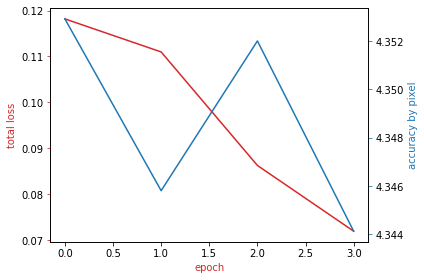

In [11]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy by pixel', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

In [ ]:
#plot coeffcients

fig, axs = plt.subplots(1, 3, figsize=(12, 6))
axs[0].hist(listS)
axs[0].set_title('sensitvity')
print('sensitivity:  mean='+ str(np.mean(listS))+', std='+str(np.std(listS)))
axs[1].hist(listP)
axs[1].set_title('precision')
print('precision:  mean='+ str(np.mean(listP))+', std='+str(np.std(listP)))
axs[2].hist(listDC)
axs[2].set_title('dice coeffcient')
print('dice coeffcient:  mean='+ str(np.mean(listDC))+', std='+str(np.std(listDC)))
plt.show()


In [12]:
def plotresult(x):
    z=model(x['image'].view(-1,1,128,128).float().to(device))
    _, yhat = torch.max(z.data, 1)
    yhat=yhat.to('cpu').detach()[0]
    fig, axs = plt.subplots(1, 2, figsize=(8, 8))
    axs[0].imshow(x['mask'][0],cmap='gray')
    axs[0].set_title('ground-truth')
    axs[1].imshow(yhat,cmap='gray')
    axs[1].set_title('network output') 
    plt.show()
    

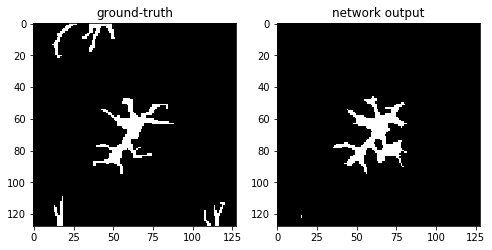

sensitivity = 0.5656324582338902
precision = 0.6666666666666666
dice coeffcient = 0.6120077469335055


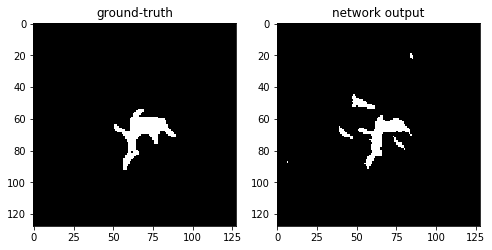

sensitivity = 0.6351931330472103
precision = 0.6757990867579908
dice coeffcient = 0.6548672566371682


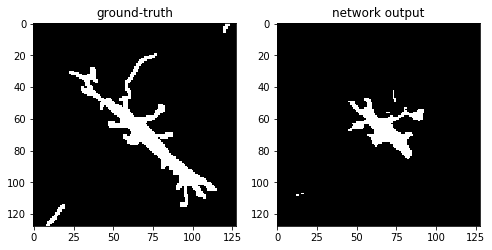

sensitivity = 0.3788546255506608
precision = 0.8403908794788274
dice coeffcient = 0.5222672064777328


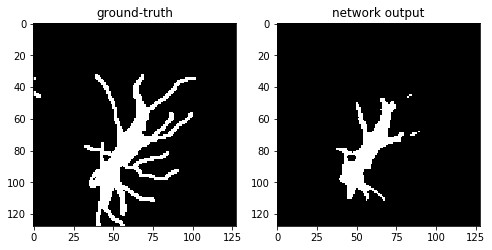

sensitivity = 0.49971048060220036
precision = 0.9567627494456763
dice coeffcient = 0.6565233929250666


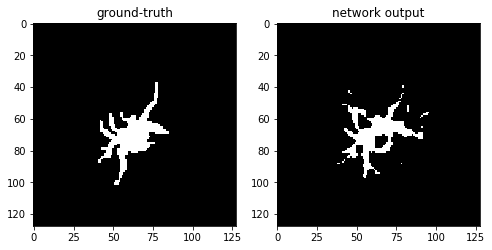

sensitivity = 0.7810026385224275
precision = 0.8076398362892224
dice coeffcient = 0.7940979208584842


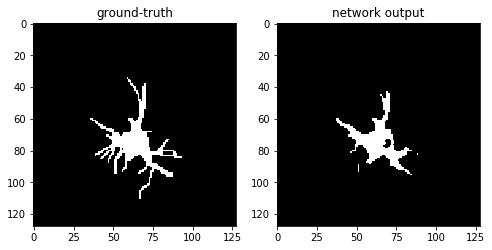

sensitivity = 0.6939040207522698
precision = 0.8916666666666667
dice coeffcient = 0.7804522246535376


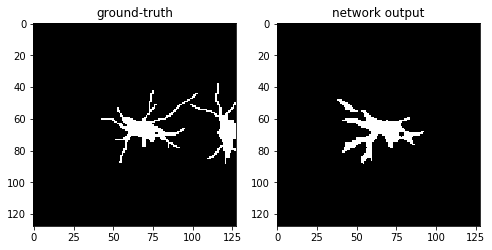

sensitivity = 0.4601889338731444
precision = 0.6003521126760564
dice coeffcient = 0.5210084033613446


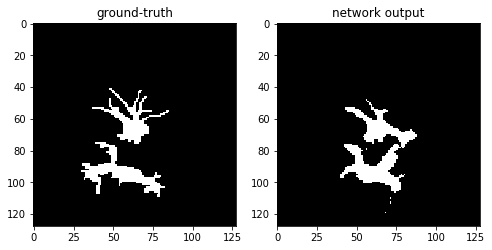

sensitivity = 0.6659505907626209
precision = 0.6724511930585684
dice coeffcient = 0.6691851052347545


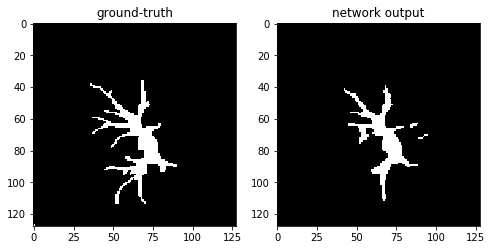

sensitivity = 0.7023675310033822
precision = 0.8862019914651493
dice coeffcient = 0.7836477987421384


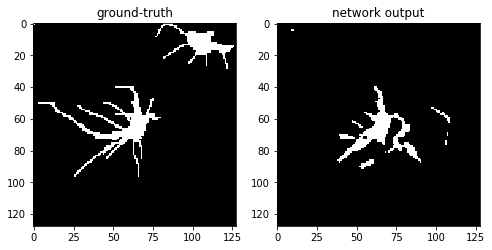

sensitivity = 0.366600790513834
precision = 0.5936
dice coeffcient = 0.45326817348808796


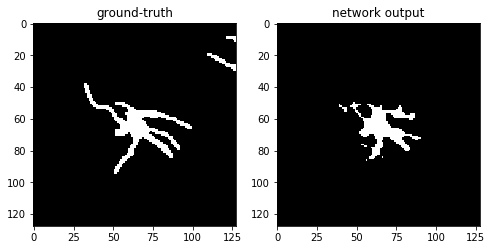

sensitivity = 0.603359173126615
precision = 0.8475499092558983
dice coeffcient = 0.7049056603773585


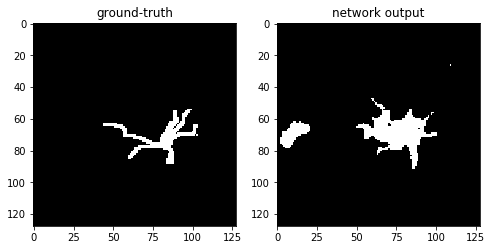

sensitivity = 0.7400468384074942
precision = 0.3442265795206972
dice coeffcient = 0.46988847583643123


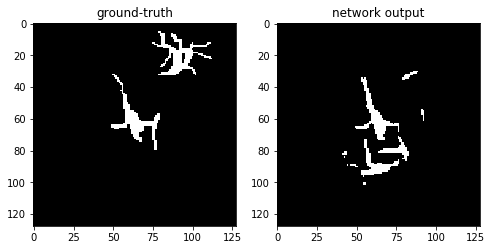

sensitivity = 0.37438423645320196
precision = 0.43761996161228406
dice coeffcient = 0.40353982300884955


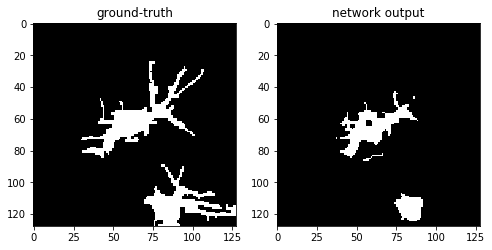

sensitivity = 0.45689149560117304
precision = 0.9111111111111111
dice coeffcient = 0.60859375


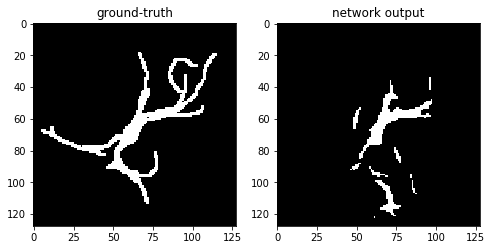

sensitivity = 0.38893476465730803
precision = 0.7429022082018928
dice coeffcient = 0.510569105691057


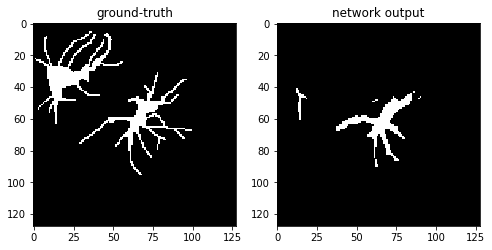

sensitivity = 0.31009023789991796
precision = 0.7283236994219653
dice coeffcient = 0.43498273878020716


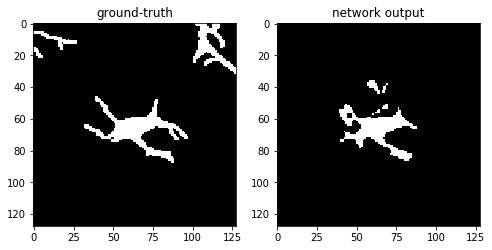

sensitivity = 0.4419237749546279
precision = 0.7389984825493171
dice coeffcient = 0.5530948324815446


In [13]:
for index in range(len(validation_dataset)):
    plotresult(validation_dataset[index])
    x=validation_dataset[index]
    z=z=model(x['image'].view(-1,1,128,128).float().to(device))
    _, yhat = torch.max(z.data, 1)
    yhat=yhat.to('cpu').detach()[0]
    print('sensitivity = '+str(sensitivity(yhat.numpy(), x['mask'][0].numpy())))
    print('precision = '+ str(precision(yhat.numpy(), x['mask'][0].numpy())))
    print('dice coeffcient = '+ str(diceCoef(yhat.numpy(), x['mask'][0].numpy())))
    
    